In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output
import torch.multiprocessing as mp
from tqdm import tqdm
import torch

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=128,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
    bin_size=0,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=128,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
    bin_size=0,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


tensor([[[ 1.0000e+00, -8.7409e-08,  1.5257e-09],
         [ 0.0000e+00,  1.7452e-02,  9.9985e-01],
         [-8.7423e-08, -9.9985e-01,  1.7452e-02]]], device='cuda:0') tensor([[-0.0000e+00, 5.9605e-08, 3.0000e+01]], device='cuda:0')


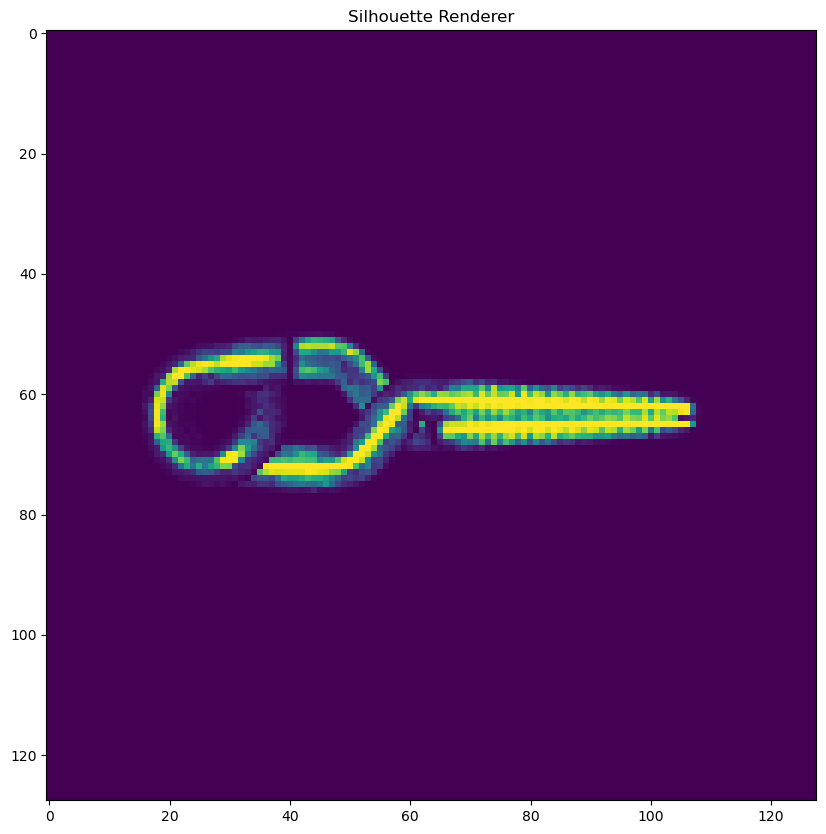

In [6]:
# Select the viewpoint using spherical angles
distance = 30   # distance from camera to the object
elevation = -89.0   # angle of elevation in degrees
azimuth = 180.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R_t, T_t = look_at_view_transform(distance, elevation, azimuth, device=device)
print(R_t, T_t)

# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)

silhouette = silhouette.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.title("Silhouette Renderer")
plt.grid(False)

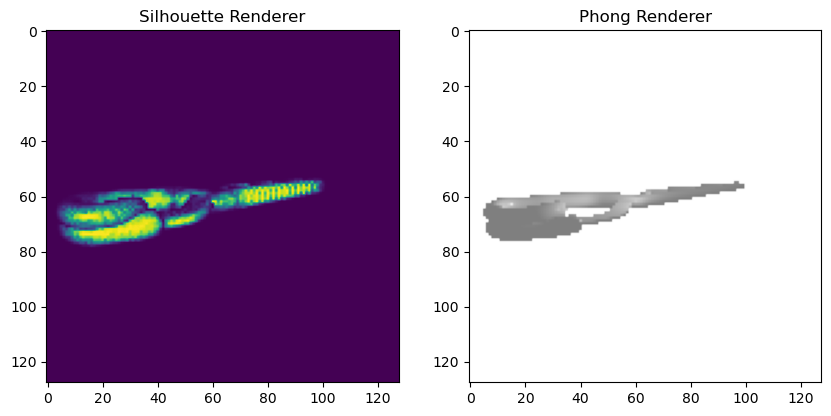

In [8]:
# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R_t, T=T_t)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.title("Silhouette Renderer")
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.title("Phong Renderer")
plt.grid(False)

In [8]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([20.0,  20.0, +20.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.mean((image[..., 3] - self.image_ref) ** 2)
        return loss, image

In [9]:
# We will save images periodically and compose them into a GIF.
#filename_output = "./teapot_optimization_demo.gif"
#writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

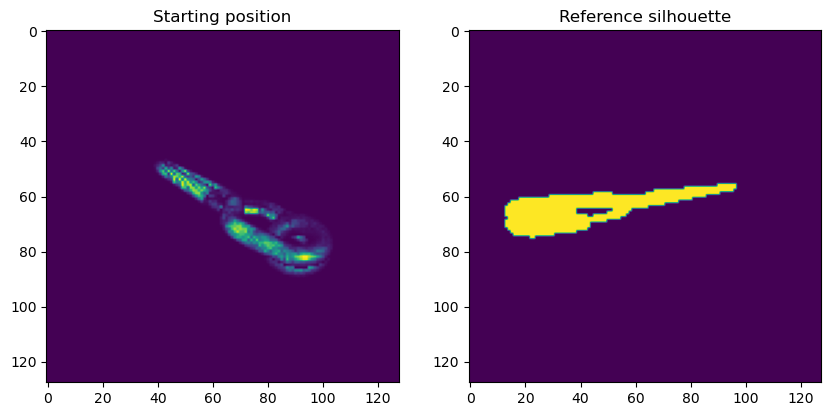

In [10]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

plt.show()

In [70]:
# Function to generate a random camera position within a safe distance
def random_camera_position(min_distance, max_distance, device):
    distance = np.random.uniform(min_distance, max_distance)
    azimuth = np.random.uniform(0, 360)  # Degrees
    elevation = np.random.uniform(-90, 90)  # Degrees
    x = distance * np.cos(np.radians(elevation)) * np.cos(np.radians(azimuth))
    y = distance * np.cos(np.radians(elevation)) * np.sin(np.radians(azimuth))
    z = distance * np.sin(np.radians(elevation))
    return torch.tensor([x, y, z], device=device, dtype=torch.float32)

# Function to generate a new camera position near a given reference position
def random_nearby_position(reference_position, deviation, device):
    noise = np.random.uniform(-deviation, deviation, size=(3,))  # Generate random noise in x, y, z
    new_position = reference_position.cpu().numpy() + noise  # Apply noise to the reference position
    return torch.tensor(new_position, device=device, dtype=torch.float32)  # Convert to tensor on the correct device

# Function to generate diverse test target positions
def generate_target_positions(min_distance, max_distance, num_points):
    azimuths = np.random.uniform(0, 180, num_points)  # Random azimuth angles in degrees
    elevations = np.random.uniform(-90, 90, num_points)  # Random elevations in degrees
    distances = np.random.uniform(min_distance, max_distance, num_points)  # Random distances

    target_positions = []
    for i in range(num_points):
        az, el, d = azimuths[i], elevations[i], distances[i]
        x = d * np.cos(np.radians(el)) * np.cos(np.radians(az))
        y = d * np.cos(np.radians(el)) * np.sin(np.radians(az))
        z = d * np.sin(np.radians(el))
        target_positions.append([x, y, z])

    return torch.tensor(target_positions, dtype=torch.float32)

# 🔹 Function to visualize results (called only if visualize=True)
def visualize_results(loss_values, restart_num, refined=False):
    restart_type = "Refined Restart" if refined else "Restart"
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label=f"Loss ({restart_type} {restart_num + 1})")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss ({restart_type} {restart_num + 1})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to compute atomic error for a given optimization result
def compute_atomic_error(best_camera_position, target_position, model, clip_mesh):
    scale_factor = 1.0  # Adjust to match desired unit system

    # Step 1: Get the bounding box of the target mesh
    verts_target = clip_mesh.verts_packed() * scale_factor  # Apply scale factor
    bbox_min = verts_target.min(dim=0).values
    bbox_max = verts_target.max(dim=0).values
    bbox_dimensions = bbox_max - bbox_min  # Bounding box dimensions (in desired units)

    # Step 2: Apply the final camera transformation
    R_f = look_at_rotation(best_camera_position[None, :], device=model.device)  # Predicted rotation matrix
    T_f = -torch.bmm(R_f.transpose(1, 2), best_camera_position[None, :, None])[:, :, 0]  # Predicted translation vector

    # Transform the final estimated mesh vertices
    verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]

    # Step 3: Compute the transformation for the target position
    R_t = look_at_rotation(target_position[None, :], device=model.device)  # Ground truth rotation matrix
    T_t = -torch.bmm(R_t.transpose(1, 2), target_position[None, :, None])[:, :, 0]  # Ground truth translation vector

    # Transform the target vertices to the ground truth view space
    verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]

    # Step 4: Compute atomic errors (point-wise Euclidean distance)
    deviations = torch.norm(verts_target_transformed - verts_final, dim=1)  # Euclidean distance for each vertex
    max_deviation = deviations.max().item()  # Maximum deviation (in desired units)

    return max_deviation

In [118]:
def compute_image_loss(model, target_image):
    """
    Computes the loss between the rendered image from the model and the target grayscale image.
    """
    # Get the rendered image (unpack properly)
    rendered_output = model()
    if isinstance(rendered_output, tuple):
        rendered_image = rendered_output[1]  # Extract the image part
    else:
        rendered_image = rendered_output  # Directly use if it's not a tuple

    # Ensure grayscale conversion for RGB(A) images
    if rendered_image.shape[-1] == 4:  # Remove alpha channel if present
        rendered_image = rendered_image[..., :3]  # Keep only RGB

    if rendered_image.shape[-1] == 3:  # Convert RGB to grayscale
        rendered_image = 0.2989 * rendered_image[..., 0] + 0.5870 * rendered_image[..., 1] + 0.1140 * rendered_image[..., 2]

    # Ensure correct shape for interpolation
    if rendered_image.dim() == 2:  # If already (H, W), add batch and channel dimensions
        rendered_image = rendered_image.unsqueeze(0).unsqueeze(0)
    elif rendered_image.dim() == 3:  # If (H, W, C), add batch dimension
        rendered_image = rendered_image.permute(2, 0, 1).unsqueeze(0)  # Convert to (1, C, H, W)
    else:
        raise ValueError(f"Unexpected rendered_image shape: {rendered_image.shape}")

    # Resize if necessary
    target_shape = (1, 1, *target_image.shape[-2:])  # Match to (1, 1, H, W)
    if rendered_image.shape != target_shape:
        rendered_image = torch.nn.functional.interpolate(
            rendered_image, size=target_image.shape[-2:], mode='bilinear', align_corners=False
        )

    # Remove batch/channel dimension after resizing
    rendered_image = rendered_image.squeeze(0).squeeze(0)

    # Compute Mean Squared Error (MSE) loss
    loss = torch.nn.functional.mse_loss(rendered_image, target_image)

    return loss, rendered_image


In [124]:
# ====== Visualization Functions ======

def plot_loss_curve(loss_values, title):
    """
    Plots the loss curve for a given optimization restart.
    
    Args:
        loss_values (list): List of loss values recorded during training.
        title (str): Title for the loss plot.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(loss_values, label="Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    #plt.ylim(0, 0.05)
    plt.show()


def visualize_final_results(best_camera_position, device):
    """
    Visualizes the final estimated camera position by rendering and displaying it.
    
    Args:
        best_camera_position (torch.Tensor): The optimized camera position.
        device (torch.device): The device used for rendering.
    """
    model.camera_position.data = best_camera_position

    final_rendered_image = phong_renderer(
        meshes_world=model.meshes.clone(),
        R=look_at_rotation(model.camera_position[None, :], device=model.device),
        T=-torch.bmm(
            look_at_rotation(model.camera_position[None, :], device=model.device).transpose(1, 2),
            model.camera_position[None, :, None]
        )[:, :, 0]
    )[0, ..., :3].detach().cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
    plt.title("Target Binary Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final_rendered_image)
    plt.title("Best Rendered Image")
    plt.axis("off")
    plt.show()

In [125]:
import torchvision.transforms as transforms
from PIL import Image

def load_grayscale_image(image_path, device, resolution=128):
    # Load image using PIL and convert to grayscale ("L" mode)
    image = Image.open(image_path).convert("L")

    # Define transformation pipeline
    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),  # Resize to (128,128)
        transforms.ToTensor(),  # Convert to tensor and scale to [0,1]
    ])

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1, 1, H, W)

    # Move to the correct device
    return image_tensor.to(device)

def display_image(image_tensor):
    """
    Displays a grayscale image from a tensor.

    Args:
        image_tensor (torch.Tensor): Image tensor with shape (1, H, W).
    """
    image_np = image_tensor.cpu().squeeze().numpy()  # Move to CPU and convert to NumPy
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np, cmap="gray")  # Display as grayscale
    plt.axis("off")
    plt.title("Target Image")
    plt.show()

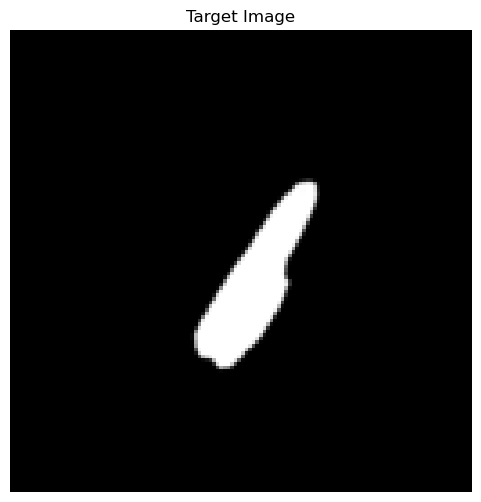

In [126]:
image_path = "/home/exouser/pose_estim/clipestimator/data/baseline/segment/bin_baseline1.png"
target_image = load_grayscale_image(image_path, device)
display_image(target_image)

In [127]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

def optimize_camera_position(target_image, device, visualize=False):
    """
    Optimizes the camera position by minimizing the image loss between the rendered image
    and the given grayscale target image.

    Parameters:
        - target_image (torch.Tensor): Grayscale target image tensor (H, W).
        - device (torch.device): The device to run the optimization on.
        - visualize (bool): Whether to visualize loss curves and results.

    Returns:
        dict: Dictionary containing optimization results.
    """
    
    # Ensure the target image is on the correct device and normalized
    target_image = target_image.to(device).float()
    if target_image.max() > 1:
        target_image /= 255.0  # Normalize to range [0,1] if needed

    # Hyperparameters
    num_initial_restarts = 10
    num_refined_restarts = 5
    num_iterations_min = 100
    num_iterations_max = 300
    patience = 15
    significant_improvement = 0.001
    nearby_deviation = 5.0

    best_loss = float('inf')
    best_camera_position = None

    # Initial Random Restarts
    all_restart_results = []
    
    for restart in range(num_initial_restarts):
        print(f"Initial Restart {restart + 1}/{num_initial_restarts}")

        # Initialize a random camera position
        model.camera_position.data = random_camera_position(40, 50, device)
        optimizer = optim.Adam([model.camera_position], lr=0.1)
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()

            # Render the image with the current camera position
            loss, rendered_image = compute_image_loss(model, target_image)

            # Backpropagate
            loss.backward()
            torch.nn.utils.clip_grad_norm_([model.camera_position], max_norm=1.0)
            optimizer.step()

            loss_values.append(loss.item())

            # Check for early stopping
            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0  # Reset counter if improvement is significant

            prev_loss = loss.item()

            if no_improve_counter >= patience and i >= num_iterations_min:
                print(f"Early stopping at iteration {i} for restart {restart + 1}")
                break

        # Save restart results
        restart_result = {
            'restart_id': restart,
            'final_loss': loss_values[-1],
            'camera_position': model.camera_position.data.clone(),
            'loss_values': loss_values
        }
        all_restart_results.append(restart_result)

        # Update best model
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()

        if visualize:
            plot_loss_curve(loss_values, title=f"Training Loss (Restart {restart + 1})")

    # Identify the best initial restart
    best_initial_restart = min(all_restart_results, key=lambda x: x['final_loss'])
    print(f"Best Initial Restart: {best_initial_restart['restart_id']} with Loss {best_initial_restart['final_loss']}")

    # Refined Restarts near the best initial restart
    for restart in range(num_refined_restarts):
        print(f"Refined Restart {restart + 1}/{num_refined_restarts}")

        model.camera_position.data = random_nearby_position(best_initial_restart['camera_position'], nearby_deviation, device)
        optimizer = optim.Adam([model.camera_position], lr=0.05)
        loss_values = []
        prev_loss = float('inf')
        no_improve_counter = 0

        for i in range(num_iterations_max):
            optimizer.zero_grad()

            # Render image and compute loss
            loss, rendered_image = compute_image_loss(model, target_image)

            loss.backward()
            torch.nn.utils.clip_grad_norm_([model.camera_position], max_norm=1.0)
            optimizer.step()

            loss_values.append(loss.item())

            if loss.item() >= prev_loss - significant_improvement:
                no_improve_counter += 1
            else:
                no_improve_counter = 0  # Reset counter if improvement is significant

            prev_loss = loss.item()

            if no_improve_counter >= patience and i >= num_iterations_min:
                print(f"Early stopping at iteration {i} for refined restart {restart + 1}")
                break

        # Update best model
        if loss_values[-1] < best_loss:
            best_loss = loss_values[-1]
            best_camera_position = model.camera_position.data.clone()

        if visualize:
            plot_loss_curve(loss_values, title=f"Training Loss (Refined Restart {restart + 1})")

    # Compute deviation/error
    estimated_position = best_camera_position

    if visualize:
        visualize_final_results(best_camera_position, device)

    return {
        "target_image": target_image.cpu().numpy(),
        "estimated_pos": estimated_position.cpu().numpy(),
        "final_loss": best_loss
    }


Initial Restart 1/10


/tmp/ipykernel_4185/952176884.py:38: UserWarning:

Using a target size (torch.Size([1, 1, 128, 128])) that is different to the input size (torch.Size([128, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Early stopping at iteration 100 for restart 1


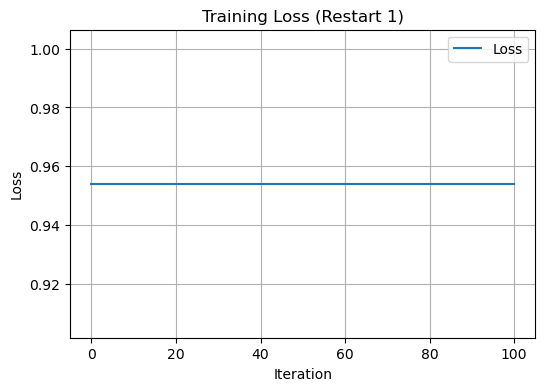

Initial Restart 2/10
Early stopping at iteration 100 for restart 2


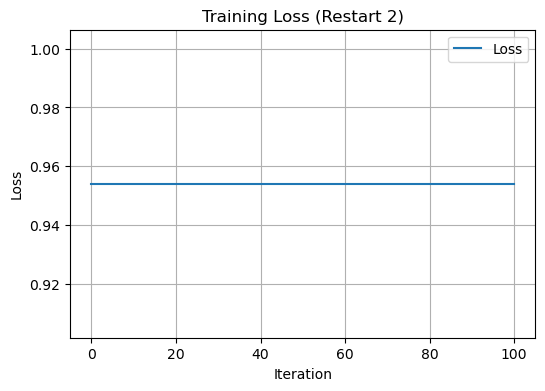

Initial Restart 3/10
Early stopping at iteration 100 for restart 3


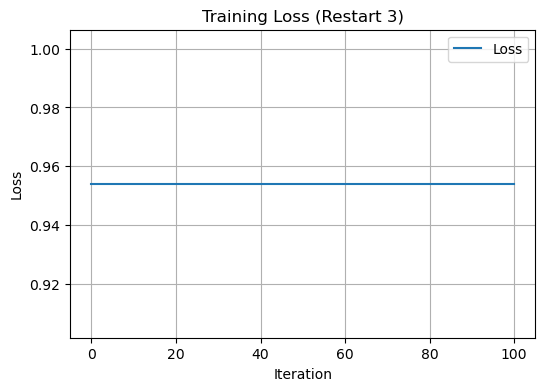

Initial Restart 4/10
Early stopping at iteration 100 for restart 4


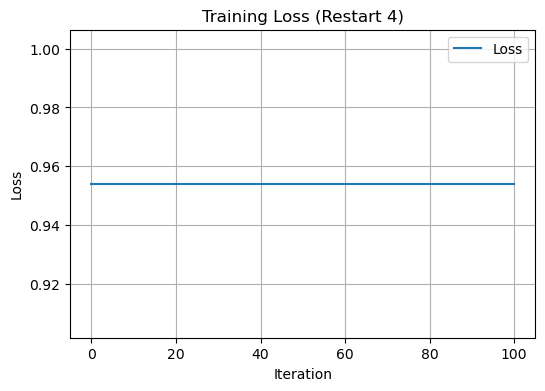

Initial Restart 5/10
Early stopping at iteration 100 for restart 5


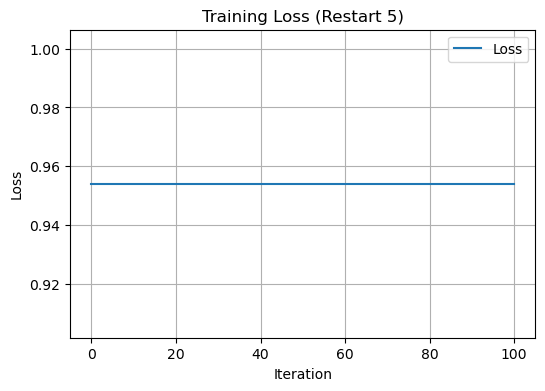

Initial Restart 6/10
Early stopping at iteration 100 for restart 6


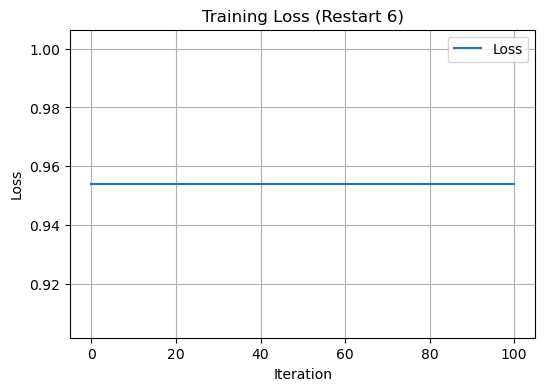

Initial Restart 7/10
Early stopping at iteration 100 for restart 7


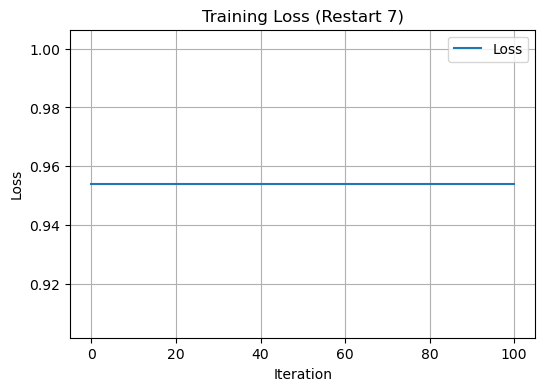

Initial Restart 8/10
Early stopping at iteration 100 for restart 8


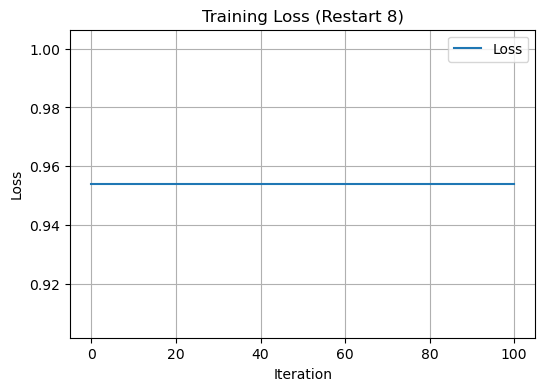

Initial Restart 9/10
Early stopping at iteration 100 for restart 9


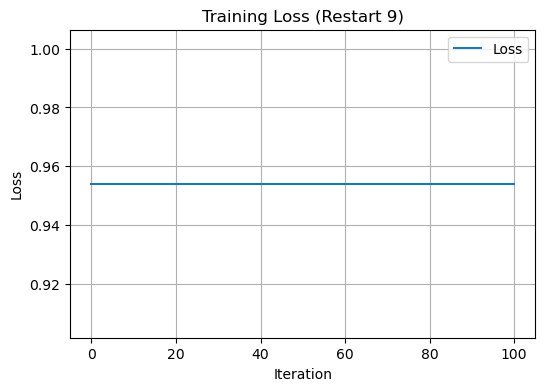

Initial Restart 10/10
Early stopping at iteration 100 for restart 10


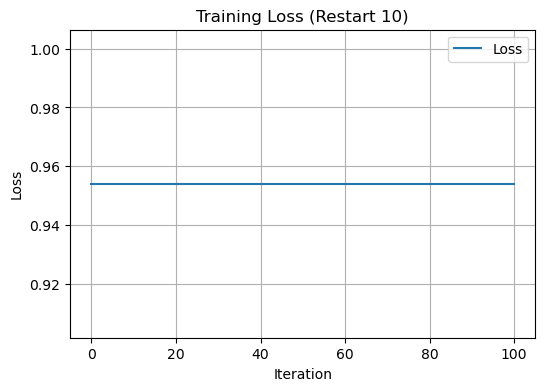

Best Initial Restart: 0 with Loss 0.9540092349052429
Refined Restart 1/5
Early stopping at iteration 100 for refined restart 1


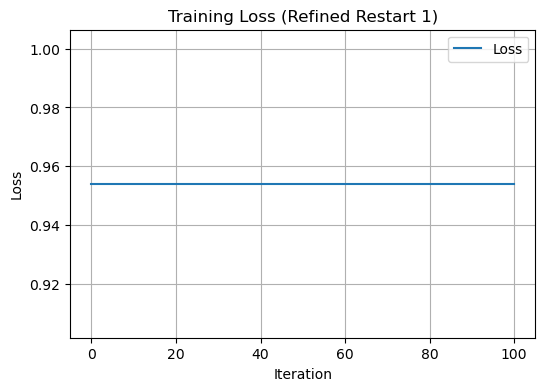

Refined Restart 2/5
Early stopping at iteration 100 for refined restart 2


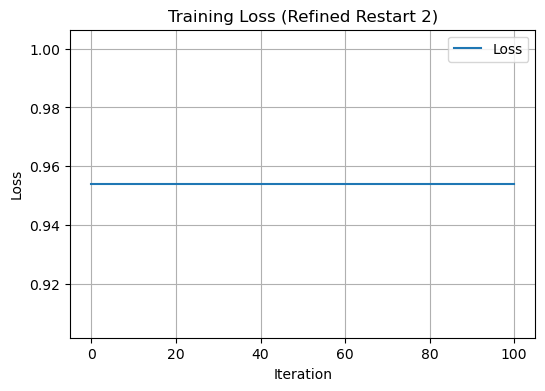

Refined Restart 3/5
Early stopping at iteration 100 for refined restart 3


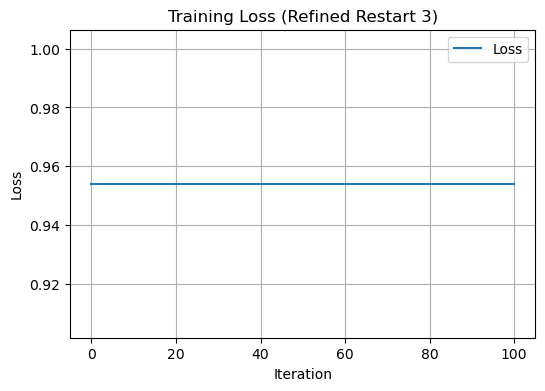

Refined Restart 4/5
Early stopping at iteration 100 for refined restart 4


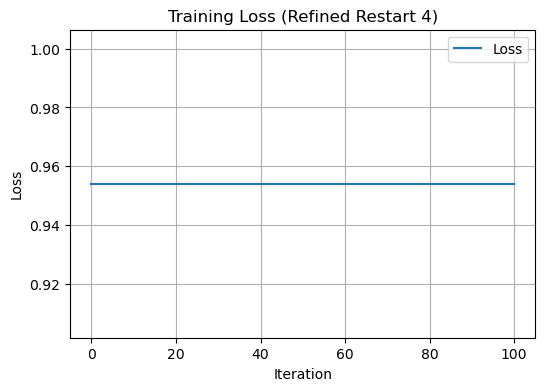

Refined Restart 5/5
Early stopping at iteration 100 for refined restart 5


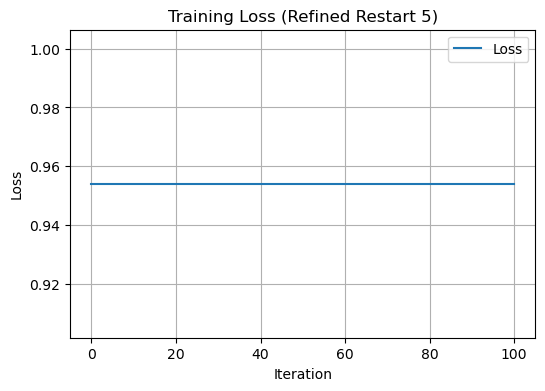

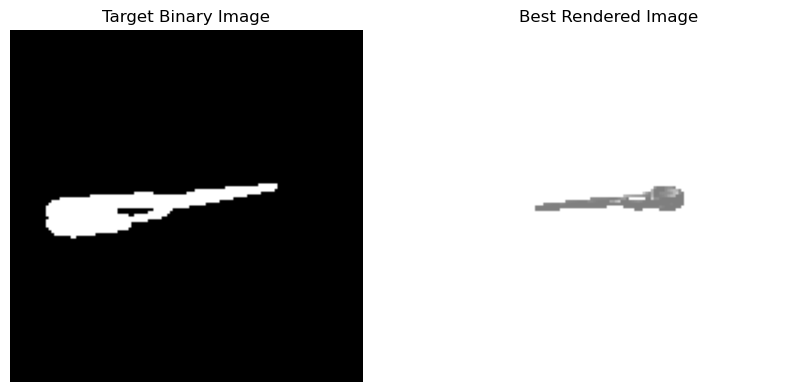

In [128]:
trial = optimize_camera_position(target_image, device, visualize=True)

In [98]:
import numpy as np
import torch
import plotly.graph_objects as go
from tqdm import tqdm
#from pytorch3d.transforms import look_at_rotation

# Run optimizer and compute atomic error for each target position
num_targets = 1  # Number of test positions
target_positions = generate_target_positions(30, 50, num_targets)  # Generate random targets

results = []
device = torch.device("cuda:0")

print("Running optimizer for multiple target positions...")
for target_pos in tqdm(target_positions):
    result = optimize_camera_position(target_pos, device)
    atomic_error = compute_atomic_error(
        best_camera_position=torch.tensor(result["estimated_pos"], device=device),
        target_position=torch.tensor(result["target_pos"], device=device),
        model=model,
        clip_mesh=clip_mesh
    )
    result["atomic_error"] = atomic_error  # Store atomic error
    results.append(result)

# Convert results to NumPy arrays for plotting
positions = np.array([r["target_pos"] for r in results])
atomic_errors = np.array([r["atomic_error"] for r in results])

# Extract vertices of the clip mesh
verts_clip = clip_mesh.verts_packed().cpu().numpy()

# Set the color scale range
hard_min = 0  # Always start at zero
soft_max = np.max(atomic_errors) * 1.1  # Slightly above the highest atomic error (10% buffer)

# 🔹 Create the 3D scatter plot for target positions (colored by atomic error)
scatter = go.Scatter3d(
    x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
    mode='markers',
    marker=dict(
        size=6,
        color=atomic_errors,  # Color by actual atomic error
        colorscale='Viridis',
        cmin=hard_min,  # Hard minimum at zero
        cmax=soft_max,  # Soft maximum slightly above the highest atomic error
        showscale=True,
        colorbar=dict(title="Atomic Error (mm)")
    ),
    name="Target Positions"
)

# 🔹 Create the 3D scatter plot for the clip mesh
clip_mesh_scatter = go.Scatter3d(
    x=verts_clip[:, 0], y=verts_clip[:, 1], z=verts_clip[:, 2],
    mode='markers',
    marker=dict(size=1, color='gray', opacity=0.3),
    name="Clip Mesh"
)

# 🔹 Create the figure with normalized axes
fig = go.Figure(data=[clip_mesh_scatter, scatter])

fig.update_layout(
    title="Target Position Difficulty Map with Clip Mesh (Atomic Error)",
    scene=dict(
        xaxis=dict(title="X Position"),
        yaxis=dict(title="Y Position"),
        zaxis=dict(title="Z Position"),
        aspectmode="cube"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

Running optimizer for multiple target positions...


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Restart 1/15
Initial Restart 6/15
Initial Restart 11/15
Best Initial Restart: 6 | Loss: 0.016024157404899597
Refined Restart 1/5
Refined Restart 3/5
Refined Restart 5/5


100%|██████████| 1/1 [02:24<00:00, 144.80s/it]


In [96]:
# Define the scale factor to convert mesh units to the desired unit system
scale_factor = 1.0  # Adjust as needed

# Step 1: Compute the bounding box dimensions of the target mesh
verts_target = clip_mesh.verts_packed().to(model.device) * scale_factor  # Apply the scale factor
bbox_min = verts_target.min(dim=0).values  # Min corner of the bounding box
bbox_max = verts_target.max(dim=0).values  # Max corner of the bounding box
bbox_dimensions = bbox_max - bbox_min  # Dimensions of the bounding box (in desired units)

# Step 2: Apply the final camera transformation to the mesh vertices
estimated_camera_position = torch.tensor(trial["estimated_pos"], device=model.device, dtype=torch.float32).view(1, 3)
target_camera_position = torch.tensor(trial["target_pos"], device=model.device, dtype=torch.float32).view(1, 3)

# Ensure `up` vector has the same batch dimension as `target_camera_position`
up_vector = torch.tensor([[0.0, 1.0, 0.0]], device=model.device).expand(target_camera_position.shape[0], -1)

R_f = look_at_rotation(estimated_camera_position, up=up_vector, device=model.device)  # Final rotation matrix
T_f = -torch.bmm(R_f.transpose(1, 2), estimated_camera_position[:, :, None])[:, :, 0]  # Final translation vector

print(f"Predicted R = {R_f}")
print(f"Predicted T = {T_f}")

# Transform the vertices of the final mesh using the estimated camera transformation
verts_final = torch.matmul(verts_target, R_f.transpose(1, 2)[0]) + T_f[0]  # Apply R and T

# Apply transformation to the target position
R_t = look_at_rotation(target_camera_position, up=up_vector, device=model.device)  # Target rotation matrix
T_t = -torch.bmm(R_t.transpose(1, 2), target_camera_position[:, :, None])[:, :, 0]  # Target translation vector

verts_target_transformed = torch.matmul(verts_target, R_t.transpose(1, 2)[0]) + T_t[0]  # Apply target transformation

# Step 3: Compute deviations between transformed target and final vertices
deviations = torch.norm(verts_target_transformed - verts_final, dim=1)  # Euclidean distance for each vertex
max_deviation = deviations.max().item()  # Maximum deviation (in desired units)

# Step 4: Report the results
print("Bounding Box Dimensions (in desired units):", bbox_dimensions.cpu().numpy())
print(f"Maximum Deviation (in desired units): {max_deviation}")
print("verts_target_transformed:")
print(verts_target_transformed)
print("verts_final:")
print(verts_final)


Predicted R = tensor([[[ 0.8729, -0.1282, -0.4707],
         [-0.0000,  0.9648, -0.2629],
         [ 0.4878,  0.2295,  0.8422]]], device='cuda:0')
Predicted T = tensor([[-9.5367e-07, -0.0000e+00,  3.1438e+01]], device='cuda:0')
Bounding Box Dimensions (in desired units): [24.488085   2.680991   6.3696203]
Maximum Deviation (in desired units): 17.679790496826172
verts_target_transformed:
tensor([[  7.5413,   1.0805,  45.6886],
        [  7.4663,   1.2622,  45.9681],
        [  7.3569,   1.2855,  46.3054],
        ...,
        [-11.3900,   0.7421,  43.5392],
        [-11.4199,   0.7451,  43.5742],
        [-11.4464,   0.7488,  43.6148]], device='cuda:0')
verts_final:
tensor([[  7.4931,   1.3362,  32.3877],
        [  7.3489,   1.4915,  32.6558],
        [  7.1649,   1.4834,  32.9598],
        ...,
        [-10.4251,   0.7202,  25.9312],
        [-10.4623,   0.7196,  25.9585],
        [-10.4974,   0.7191,  25.9921]], device='cuda:0')


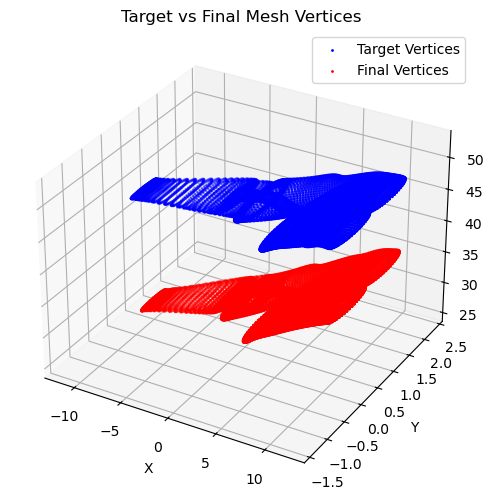

In [97]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to NumPy arrays for plotting
verts_target_np = verts_target_transformed.cpu().numpy()
verts_final_np = verts_final.cpu().numpy()

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the target mesh vertices
ax.scatter(
    verts_target_np[:, 0], verts_target_np[:, 1], verts_target_np[:, 2],
    c='blue', label='Target Vertices', s=1
)

# Plot the final mesh vertices
ax.scatter(
    verts_final_np[:, 0], verts_final_np[:, 1], verts_final_np[:, 2],
    c='red', label='Final Vertices', s=1
)

ax.set_title("Target vs Final Mesh Vertices")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()
